Generating datasets...
Test set: 100000 samples
Training set: 100 samples
Training set: 500 samples
Training set: 1000 samples
Training set: 5000 samples
Training set: 10000 samples

Evaluating theoretically optimal MAP classifier...
Optimal classifier test error: 0.1339 (13.39%)

--------------------------------------------------------------------------------
Model order selection and training for each dataset...

Training set size: 100
Performing 10-fold cross-validation...
  Testing P=4 perceptrons... Avg error: 0.7400 (0.3s)
  Testing P=8 perceptrons... Avg error: 0.7100 (0.2s)
  Testing P=16 perceptrons... Avg error: 0.6700 (0.2s)
  Testing P=32 perceptrons... Avg error: 0.7400 (0.4s)
  Testing P=64 perceptrons... Avg error: 0.5300 (0.5s)

Best number of perceptrons: 64
Training completed in 0.2s

Results for N=100:
  Best P: 64
  Test error: 0.1758 (17.58%)

--------------------------------------------------------------------------------
Training set size: 500
Performing 10-fold 

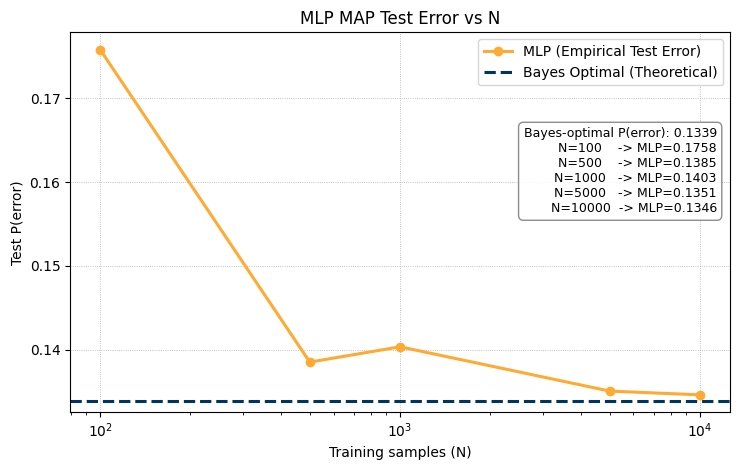

Saved: q1_test_error_vs_N.png


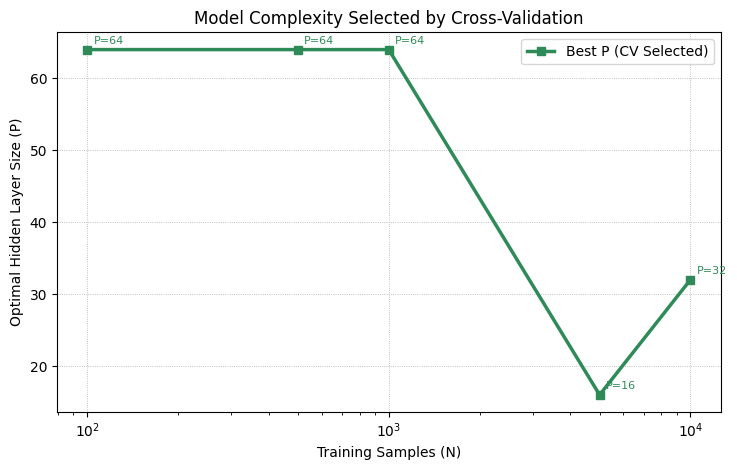

Saved: q1_cv_model_complexity.png


SUMMARY TABLE
Train Size     Best P         Test Error     Test Error %   
--------------------------------------------------------------------------------
100            64             0.1758         17.58          
500            64             0.1385         13.85          
1000           64             0.1403         14.03          
5000           16             0.1351         13.51          
10000          32             0.1346         13.46          
--------------------------------------------------------------------------------
Optimal        -              0.1339         13.39          

Results saved: q1_test_error_vs_N.png, q1_cv_model_complexity.png, q1_results_summary.csv, q1_cv_maps.json


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import time, json, csv

rng = np.random.default_rng(42)
D, C = 3, 4
priors = np.ones(C) / C

means = np.array([
    [-2.0,  0.0,  0.5],
    [ 2.0,  0.0, -0.2],
    [ 0.0,  2.2,  0.0],
    [ 0.0, -2.2,  0.2],
])

base_covs = np.array([
    [[1.2, 0.2, 0.1],
     [0.2, 1.0, 0.1],
     [0.1, 0.1, 0.9]],
    [[1.0, -0.1, 0.1],
     [-0.1, 1.1, 0.2],
     [0.1, 0.2, 1.0]],
    [[0.9, 0.1, 0.0],
     [0.1, 1.2, 0.2],
     [0.0, 0.2, 1.1]],
    [[1.1, 0.0, -0.1],
     [0.0, 0.9, 0.0],
     [-0.1, 0.0, 1.2]],
])

def logpdf_gaussian(x, mean, cov):
    Dloc = x.shape[1]
    L = np.linalg.cholesky(cov)
    xm = x - mean
    y = np.linalg.solve(L, xm.T)
    maha2 = np.sum(y**2, axis=0)
    log_det = 2*np.sum(np.log(np.diag(L)))
    return -0.5*(maha2 + Dloc*np.log(2*np.pi) + log_det)

def sample_class_conditional(n, means, covs):
    y = rng.integers(0, C, size=n)
    x = np.zeros((n, D))
    for k in range(C):
        idx = np.where(y == k)[0]
        if len(idx) > 0:
            x[idx] = rng.multivariate_normal(means[k], covs[k], size=len(idx))
    return x, y

def bayes_predict(x, means, covs, priors):
    N = x.shape[0]
    logps = np.zeros((N, C))
    for k in range(C):
        logps[:, k] = logpdf_gaussian(x, means[k], covs[k]) + np.log(priors[k])
    return np.argmax(logps, axis=1)

def bayes_error_estimate(means, covs, priors, n_test=60000):
    x, y = sample_class_conditional(n_test, means, covs)
    yhat = bayes_predict(x, means, covs, priors)
    return np.mean(yhat != y)

# Auto-tune covariance scale to hit Bayes error ~10–20%
chosen_s, chosen_err = None, None
for s in [0.6, 0.8, 1.0, 1.2, 1.5]:
    covs_try = np.array([s*base_covs[k] for k in range(C)])
    err = bayes_error_estimate(means, covs_try, priors, n_test=30000)
    if 0.10 <= err <= 0.20:
        chosen_s, chosen_err = s, err
        break
if chosen_s is None:
    chosen_s, chosen_err = 1.0, bayes_error_estimate(means, base_covs, priors, n_test=30000)
final_covs = np.array([chosen_s*base_covs[k] for k in range(C)])

def elu(z, alpha=1.0):
    out = z.copy()
    mask = z <= 0
    out[mask] = alpha*(np.exp(z[mask]) - 1)
    return out

def delu(z, alpha=1.0):
    grad = np.ones_like(z)
    mask = z <= 0
    grad[mask] = alpha*np.exp(z[mask])
    return grad

class MLP1H:
    def __init__(self, D, P, C, seed=None):
        rs = np.random.default_rng(seed)
        self.W1 = rs.normal(0, np.sqrt(2/D), size=(D, P))
        self.b1 = np.zeros(P)
        self.W2 = rs.normal(0, np.sqrt(2/P), size=(P, C))
        self.b2 = np.zeros(C)

    def forward(self, X):
        Z1 = X@self.W1 + self.b1
        H = elu(Z1)
        Z2 = H@self.W2 + self.b2
        Z2m = np.max(Z2, axis=1, keepdims=True)
        expZ = np.exp(Z2 - Z2m)
        Yhat = expZ / np.sum(expZ, axis=1, keepdims=True)
        return Yhat, (X, Z1, H, Z2, Yhat)

    def nll(self, Yhat, y):
        return -np.mean(np.log(Yhat[np.arange(len(y)), y] + 1e-12))

    def backward(self, cache, y):
        X, Z1, H, Z2, Yhat = cache
        N = X.shape[0]
        dZ2 = Yhat.copy()
        dZ2[np.arange(N), y] -= 1
        dZ2 /= N
        dW2 = H.T @ dZ2
        db2 = np.sum(dZ2, axis=0)
        dH = dZ2 @ self.W2.T
        dZ1 = dH * delu(Z1)
        dW1 = X.T @ dZ1
        db1 = np.sum(dZ1, axis=0)
        return dW1, db1, dW2, db2

    def train(self, X, y, Xval=None, yval=None, epochs=35, lr=1e-3, seed=None):
        rs = np.random.default_rng(seed)
        mW1 = np.zeros_like(self.W1); vW1 = np.zeros_like(self.W1)
        mb1 = np.zeros_like(self.b1); vb1 = np.zeros_like(self.b1)
        mW2 = np.zeros_like(self.W2); vW2 = np.zeros_like(self.W2)
        mb2 = np.zeros_like(self.b2); vb2 = np.zeros_like(self.b2)
        beta1,beta2,eps=0.9,0.999,1e-8; t=0
        best_val,best_snap=np.inf,None
        N=len(X)
        for ep in range(epochs):
            idx = rs.permutation(N)
            for start in range(0,N,128):
                b=idx[start:start+128]
                Yhat,cache=self.forward(X[b])
                dW1,db1,dW2,db2=self.backward(cache,y[b])
                for p,dp in [('W1',dW1),('b1',db1),('W2',dW2),('b2',db2)]:
                    t+=1
                    m=eval('m'+p); v=eval('v'+p)
                    m=beta1*m+(1-beta1)*dp
                    v=beta2*v+(1-beta2)*(dp**2)
                    m_hat=m/(1-beta1**t); v_hat=v/(1-beta2**t)
                    upd=lr*m_hat/(np.sqrt(v_hat)+eps)
                    setattr(self,p,getattr(self,p)-upd)
                    exec('m'+p+'=m; v'+p+'=v')
            if Xval is not None:
                Yv,_=self.forward(Xval)
                vloss=self.nll(Yv,yval)
                if vloss<best_val:
                    best_val=vloss
                    best_snap=(self.W1.copy(),self.b1.copy(),self.W2.copy(),self.b2.copy())
        if best_snap is not None:
            self.W1,self.b1,self.W2,self.b2=best_snap

    def predict(self,X):
        Yhat,_=self.forward(X)
        return np.argmax(Yhat,axis=1)

def kfold_indices(N,k=10,seed=123):
    rs=np.random.default_rng(seed)
    idx=rs.permutation(N)
    return np.array_split(idx,k)

def cv_select_P(X,y,Pgrid,epochs=20,k=10,seed=123):
    folds=kfold_indices(len(X),k,seed)
    avg_err={}
    print("Performing 10-fold cross-validation...")
    for P in Pgrid:
        t0 = time.perf_counter()
        fold_errs=[]
        for i in range(k):
            val=folds[i]; tr=np.concatenate([folds[j] for j in range(k) if j!=i])
            mlp=MLP1H(D=X.shape[1],P=P,C=len(np.unique(y)),seed=seed+i+P)
            mlp.train(X[tr],y[tr],Xval=X[val],yval=y[val],epochs=epochs,seed=seed+i+P)
            yhat=mlp.predict(X[val])
            fold_errs.append(np.mean(yhat!=y[val]))
        dt = time.perf_counter() - t0
        avg = float(np.mean(fold_errs))
        print(f"  Testing P={P} perceptrons... Avg error: {avg:.4f} ({dt:.1f}s)")
        avg_err[P]=avg
    bestP=min(avg_err,key=avg_err.get)
    print(f"\nBest number of perceptrons: {bestP}")
    return bestP,avg_err

train_sizes=[100,500,1000,5000,10000]
Pgrid={n:[4,8,16,32,64] for n in train_sizes}
print("Generating datasets...")
TEST_N = 100000
Xtest,ytest=sample_class_conditional(TEST_N,means,final_covs)
print(f"Test set: {TEST_N} samples")
for n in train_sizes:
    print(f"Training set: {n} samples")
print()

print("Evaluating theoretically optimal MAP classifier...")
bayes_line = np.mean(bayes_predict(Xtest,means,final_covs,priors)!=ytest)
print(f"Optimal classifier test error: {bayes_line:.4f} ({bayes_line*100:.2f}%)\n")

print("-"*80)
print("Model order selection and training for each dataset...\n")
results=[]; per_P_cv={}; best_Ps={}

for Ntr in train_sizes:
    print(f"Training set size: {Ntr}")
    Xtr,ytr=sample_class_conditional(Ntr,means,final_covs)
    bestP,cvmap=cv_select_P(Xtr,ytr,Pgrid[Ntr],epochs=18,k=10,seed=500+Ntr)
    per_P_cv[Ntr]=cvmap; best_Ps[Ntr]=bestP
    t0 = time.perf_counter()
    best_nll=np.inf; best_mlp=None
    for r in range(3):
        mlp=MLP1H(D=D,P=bestP,C=C,seed=900+Ntr+r)
        mlp.train(Xtr,ytr,epochs=35,seed=900+Ntr+r)
        Yhat,_=mlp.forward(Xtr)
        nll=-np.mean(np.log(Yhat[np.arange(len(ytr)),ytr]+1e-12))
        if nll<best_nll: best_nll=nll; best_mlp=mlp
    dt = time.perf_counter() - t0
    print(f"Training completed in {dt:.1f}s\n")

    yhat=best_mlp.predict(Xtest)
    test_err=np.mean(yhat!=ytest)
    results.append((Ntr,bestP,float(test_err)))

    print(f"Results for N={Ntr}:")
    print(f"  Best P: {bestP}")
    print(f"  Test error: {test_err:.4f} ({test_err*100:.2f}%)\n")
    print("-"*80)


print("Generating visualizations...")

# Figure 1: Test error vs N (MLP vs Bayes) with info box
Ns=[r[0] for r in results]; Errs=[r[2] for r in results]
plt.figure(figsize=(7.5,4.8))
plt.semilogx(Ns, Errs, color="#FFAA33", marker='o', linewidth=2.2, label='MLP (Empirical Test Error)')
plt.axhline(bayes_line, color="#003366", linestyle='--', linewidth=2.2, label='Bayes Optimal (Theoretical)')

# Add info box
info_lines = [f"Bayes-optimal P(error): {bayes_line:.4f}"]
info_lines += [f"N={n:<6d} -> MLP={e:.4f}" for n, e in zip(Ns, Errs)]
info_text = "\n".join(info_lines)
ax = plt.gca()
ax.text(0.98, 0.75, info_text, transform=ax.transAxes, fontsize=9, ha='right', va='top', bbox=dict(boxstyle='round,pad=0.4',facecolor='white', edgecolor='gray', alpha=0.9))

plt.xlabel('Training samples (N)')
plt.ylabel('Test P(error)')
plt.title('MLP MAP Test Error vs N')
plt.grid(True, linestyle=':', linewidth=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('q1_test_error_vs_N.png', dpi=200)
plt.show()
print("Saved: q1_test_error_vs_N.png")

# Figure 2: CV-selected model complexity
plt.figure(figsize=(7.5,4.8))
plt.semilogx(list(best_Ps.keys()), list(best_Ps.values()),
             marker='s', color='#2E8B57', linewidth=2.5, label='Best P (CV Selected)')
for n, p in best_Ps.items():
    plt.text(n * 1.05, p + 0.8, f"P={p}", fontsize=8, color='#2E8B57')
plt.xlabel('Training Samples (N)')
plt.ylabel('Optimal Hidden Layer Size (P)')
plt.title('Model Complexity Selected by Cross-Validation')
plt.grid(True, linestyle=':', linewidth=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('q1_cv_model_complexity.png', dpi=200)
plt.show()
print("Saved: q1_cv_model_complexity.png")

with open('q1_results_summary.csv','w',newline='') as f:
    w=csv.writer(f); w.writerow(['N_train','Best_P','Test_P_error'])
    for n,p,e in results: w.writerow([n,p,round(e,6)])

with open('q1_cv_maps.json','w') as f:
    json.dump({'bayes_error_estimate':bayes_line,
               'best_Ps':best_Ps,'per_P_cv':per_P_cv},f,indent=2)

print("\n")
print("SUMMARY TABLE")

print(f"{'Train Size':<15}{'Best P':<15}{'Test Error':<15}{'Test Error %':<15}")
print("-"*80)
for n,p,e in results:
    print(f"{n:<15}{p:<15}{e:<15.4f}{(e*100):<15.2f}")
print("-"*80)
print(f"{'Optimal':<15}{'-':<15}{bayes_line:<15.4f}{(bayes_line*100):<15.2f}")

print("\nResults saved: q1_test_error_vs_N.png, q1_cv_model_complexity.png, q1_results_summary.csv, q1_cv_maps.json")
